# Feature Importance Documentation

This IPython notebook contains documentation on how to use the feature importance tooling in ml-compiler-opt to analyze to a reasonable degree of certainty what features are contributing heavily to the output of a model and what features are not.

Start off by importing the necessary modules, primarily the `feature_importance_graphs` module. This module contains all the functionality to import explanation data and turn it into graphs that allow for analysis.

In [16]:
import sys

sys.path.append('../')

import compiler_opt.tools.feature_importance_graphs as figraphs

Now, we need to make sure that we actually have some data to visualize. Processing the data is done with a separate script, `compiler_opt/tools/feature_importance.py`. Running this script for the regalloc case might look something like this:
```bash
PYTHONPATH=$PYTHONPATH:. python3 compiler_opt/tools/feature_importance.py \
    --gin_files=compiler_opt/rl/regalloc/gin_configs/common.gin \
    --gin_bindings=config_registry.get_configuration.implementation=@configs.RegallocEvictionConfig \
    --data_path=/default_trace \
    --model_path=/warmstart/saved_policy \
    --num_examples=5 \
    --output_file=./explanation_data.json
```
This assumes that you have a trace ready at `/default_trace`. Refer to the demo/documentation in `compiler_opt/tools/generate_default_trace.py` on how to do that. You can also change the `num_examples` flag to change the number of examples that get turned into explanations. The higher the number the better results you will see when looking at overall trends in the model but also the more compute time will be used when running this script. The script is currently quite slow, especially in the regalloc case, due to a lack of multithreading.

To run explanations for a different problem such as the inliner for size, change the `gin_files` flag and the `gin_bindings` flag to their corresponding values for the inliner and make sure that the trace you are using is for the inliner.

**NOTE:** Make sure that you are running this script in the root of the repository or otherwise the path in the next step will be incorrect. You can run it outside of the root of the repository if you are comfortable changing the path below.

Now, we need to load the shap values generated by the script into the IPython notebook. Everything is saved in a human readable JSON format, and can easily be imported using the `load_shap_values` function from the `feature_importance_graphs` module. This function returns a python object containing all the data necessary to generate graphs from the data generated using the `feature_importance.py` script.

In [17]:
shap_data = figraphs.load_shap_values('../explanation_data.json')

Next, we need to make sure to initialize some JS code so that the graphs will render properly and have interactive features available. The function in the `shap` library that does this is wrapped by the `init_shap_for_notebook` function in the `feature_importance_graphs` module.

In [18]:
figraphs.init_shap_for_notebook()

Now, we can create our first graph. Let's start off by looking at a force plot of an individual example. This is handled by the `graph_individual_example` function which takes in the data that we loaded above and an index of an example to generate a plot for.

The generated plot shows the contribution of each feature to the overall model output. In addition to the contribution of specific features to the model output, the actual value of the feature is shown in some cases. This is the case for the -Oz for size inliner model, but the regalloc eviction case, the actual feature values are not present. This is due to the fact that we're summing the shap values along all of the LRs to get per feature shap values rather than per feature per LR shap values. Summing the actual model features along the same axis would produce results that are essentially meaningless and thus everything is set to zero instead.

In [19]:
figraphs.graph_individual_example(shap_data, index=0)

While force plots of individual examples can provide some insight, much better conclusions can be drawn from looking at many examples or even an entire dataset. This is what the `graph_summary_plot` function does. It takes in all of the data generated by the `feature_importance.py` script and puts it into a single plot. The horizontal axis represents the contribution of that feature to the overall output of the model with different dots representing individual examples. The color of the dot represents the actual value of that feature, but the same disclaimer in terms of the regalloc case not having actual feature data available applies.

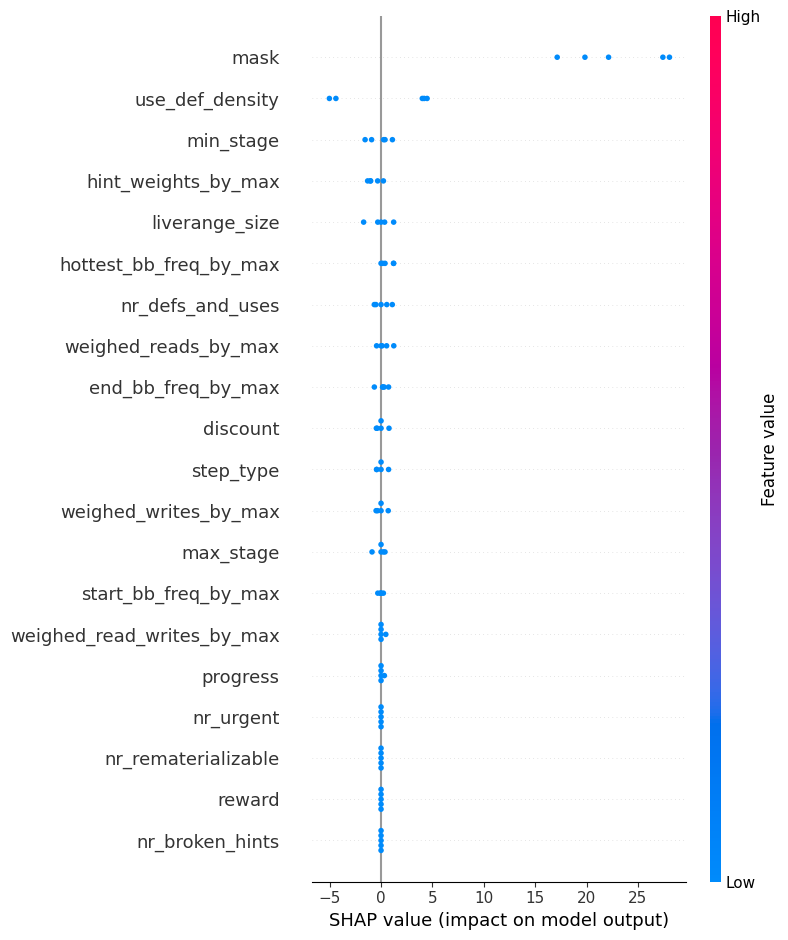

In [20]:
figraphs.graph_summary_plot(shap_data)